In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 4.3 MB/s 
     |████████████████████████████████| 1.8 MB 69.4 MB/s 
     |████████████████████████████████| 103 kB 65.7 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%
development set - fold 3,92.76%,7.24%
validation set - fold 3,92.76%,7.24%
development set - fold 4,92.76%,7.24%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0440942
[100]	valid_0's binary_logloss: 0.042186
[150]	valid_0's binary_logloss: 0.0412758
[200]	valid_0's binary_logloss: 0.0407019
[250]	valid_0's binary_logloss: 0.040185
[300]	valid_0's binary_logloss: 0.0398294
[350]	valid_0's binary_logloss: 0.0394734
[400]	valid_0's binary_logloss: 0.0391557
[450]	valid_0's binary_logloss: 0.0389183
[500]	valid_0's binary_logloss: 0.0386839
[550]	valid_0's binary_logloss: 0.0384286
[600]	valid_0's binary_logloss: 0.0382277
[650]	valid_0's binary_logloss: 0.0379921
[700]	valid_0's binary_logloss: 0.0378195
[750]	valid_0's binary_logloss: 0.037669
[800]	valid_0's binary_logloss: 0.0374814
[850]	valid_0's binary_logloss: 0.0373081
[900]	valid_0's binary_logloss: 0.0371387
[950]	valid_0's binary_logloss: 0.0369689
[1000]	valid_0's binary_logloss: 0.0368398
[1050]	valid_0's binary_logloss: 0.0367061
[1100]	valid_0's binary_logloss: 0.0365777
[1150]	valid_0's binary_logloss: 0.0364352
[1200]	valid_0's binary_logloss: 0

In [ ]:
del train_data
gc.collect()

87

#Check Feature Importances

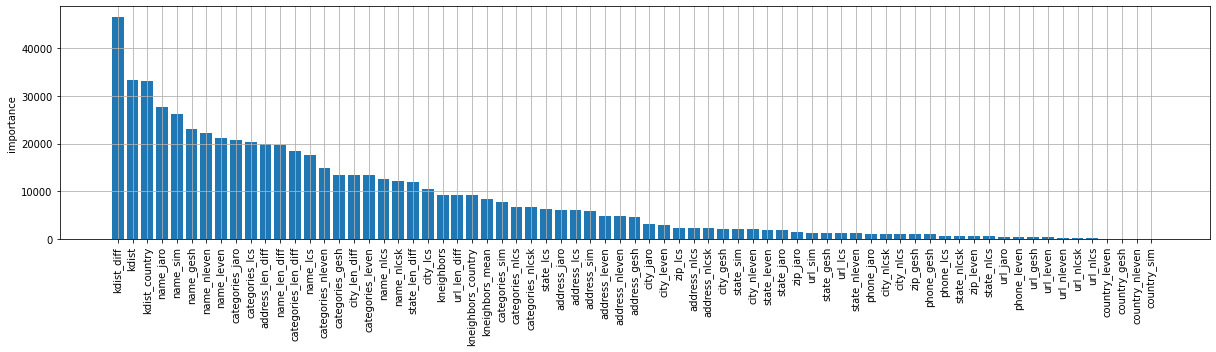

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.0 MB/s 
     |████████████████████████████████| 81 kB 10.3 MB/s 
     |████████████████████████████████| 210 kB 80.7 MB/s 
     |████████████████████████████████| 78 kB 7.7 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 112 kB 86.3 MB/s 
     |████████████████████████████████| 146 kB 70.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=b79dadb7dbca3478af3bafaa78bcecdd2aae2c8fbc92a7c37b6b3804c299b176
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-25 21:39:39,510] A new study created in memory with name: no-name-e0915cf6-5219-4d95-8a61-bde3461ed489
[I 2022-05-25 21:40:28,865] Trial 0 finished with value: 0.8258205166471335 and parameters: {'threshold': 0.8232518792001164}. Best is trial 0 with value: 0.8258205166471335.


CV: 0.825821


[I 2022-05-25 21:40:45,524] Trial 1 finished with value: 0.8208808169007246 and parameters: {'threshold': 0.24267404227655198}. Best is trial 0 with value: 0.8258205166471335.


CV: 0.820881


[I 2022-05-25 21:41:02,266] Trial 2 finished with value: 0.8030667942416171 and parameters: {'threshold': 0.9586128970368474}. Best is trial 0 with value: 0.8258205166471335.


CV: 0.803067


[I 2022-05-25 21:41:19,265] Trial 3 finished with value: 0.794761224125298 and parameters: {'threshold': 0.09466471654955322}. Best is trial 0 with value: 0.8258205166471335.


CV: 0.794761


[I 2022-05-25 21:41:35,373] Trial 4 finished with value: 0.804539448893745 and parameters: {'threshold': 0.9552000710226246}. Best is trial 0 with value: 0.8258205166471335.


CV: 0.804539


[I 2022-05-25 21:41:52,321] Trial 5 finished with value: 0.7786096603213326 and parameters: {'threshold': 0.060800995300923644}. Best is trial 0 with value: 0.8258205166471335.


CV: 0.778610


[I 2022-05-25 21:42:09,503] Trial 6 finished with value: 0.8171134243707837 and parameters: {'threshold': 0.20515175324382884}. Best is trial 0 with value: 0.8258205166471335.


CV: 0.817113


[I 2022-05-25 21:42:25,523] Trial 7 finished with value: 0.8008020084854011 and parameters: {'threshold': 0.9633273611583304}. Best is trial 0 with value: 0.8258205166471335.


CV: 0.800802


[I 2022-05-25 21:42:41,257] Trial 8 finished with value: 0.7663222139157059 and parameters: {'threshold': 0.99344148934287}. Best is trial 0 with value: 0.8258205166471335.


CV: 0.766322


[I 2022-05-25 21:42:58,194] Trial 9 finished with value: 0.8323164064832794 and parameters: {'threshold': 0.6161728115642043}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832316


[I 2022-05-25 21:43:14,235] Trial 10 finished with value: 0.8318527277576484 and parameters: {'threshold': 0.5064514534703222}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831853


[I 2022-05-25 21:43:31,116] Trial 11 finished with value: 0.8321391507016257 and parameters: {'threshold': 0.5633898701590604}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832139


[I 2022-05-25 21:43:46,740] Trial 12 finished with value: 0.8322854861155461 and parameters: {'threshold': 0.6055689430701672}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832285


[I 2022-05-25 21:44:03,176] Trial 13 finished with value: 0.8313154010107304 and parameters: {'threshold': 0.6877787243485688}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831315


[I 2022-05-25 21:44:20,129] Trial 14 finished with value: 0.8283421179463828 and parameters: {'threshold': 0.37127827492402204}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.828342


[I 2022-05-25 21:44:35,848] Trial 15 finished with value: 0.8315017622854967 and parameters: {'threshold': 0.6749612384271882}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831502


[I 2022-05-25 21:44:52,886] Trial 16 finished with value: 0.8288552608550167 and parameters: {'threshold': 0.3857135049359017}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.828855


[I 2022-05-25 21:45:09,726] Trial 17 finished with value: 0.8314756436082421 and parameters: {'threshold': 0.6778733540692189}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831476


[I 2022-05-25 21:45:25,481] Trial 18 finished with value: 0.8278504310551488 and parameters: {'threshold': 0.787664701324371}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.827850


[I 2022-05-25 21:45:42,620] Trial 19 finished with value: 0.8288045928217921 and parameters: {'threshold': 0.3836750913833439}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.828805


[I 2022-05-25 21:45:58,518] Trial 20 finished with value: 0.832175723603489 and parameters: {'threshold': 0.5664863642600907}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832176


[I 2022-05-25 21:46:15,212] Trial 21 finished with value: 0.8321537691282591 and parameters: {'threshold': 0.5703388376724129}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832154


[I 2022-05-25 21:46:32,193] Trial 22 finished with value: 0.8312737090784984 and parameters: {'threshold': 0.471293543253376}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831274


[I 2022-05-25 21:46:53,784] Trial 23 finished with value: 0.8279416005801339 and parameters: {'threshold': 0.7862045220476093}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.827942


[I 2022-05-25 21:47:10,795] Trial 24 finished with value: 0.8322982787999056 and parameters: {'threshold': 0.5979890310729457}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832298


[I 2022-05-25 21:47:27,620] Trial 25 finished with value: 0.8322867424677833 and parameters: {'threshold': 0.6204063342622017}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832287


[I 2022-05-25 21:47:43,105] Trial 26 finished with value: 0.8226663178870178 and parameters: {'threshold': 0.8614884459017992}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.822666


[I 2022-05-25 21:47:59,540] Trial 27 finished with value: 0.8305180247034794 and parameters: {'threshold': 0.7177857556438797}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.830518


[I 2022-05-25 21:48:16,249] Trial 28 finished with value: 0.8316540875831976 and parameters: {'threshold': 0.4908950667806906}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831654


[I 2022-05-25 21:48:32,131] Trial 29 finished with value: 0.8322529503327369 and parameters: {'threshold': 0.6258871924578059}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832253


[I 2022-05-25 21:48:48,629] Trial 30 finished with value: 0.8215410792839885 and parameters: {'threshold': 0.8723913700100903}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.821541


[I 2022-05-25 21:49:05,338] Trial 31 finished with value: 0.8323053190041615 and parameters: {'threshold': 0.6167186238448203}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832305


[I 2022-05-25 21:49:21,049] Trial 32 finished with value: 0.8300746305825998 and parameters: {'threshold': 0.7341383441985996}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.830075


[I 2022-05-25 21:49:37,768] Trial 33 finished with value: 0.8308955138728242 and parameters: {'threshold': 0.45515312235804084}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.830896


[I 2022-05-25 21:49:54,135] Trial 34 finished with value: 0.8321664930535263 and parameters: {'threshold': 0.6332042874154183}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832166


[I 2022-05-25 21:50:11,222] Trial 35 finished with value: 0.8244527168866062 and parameters: {'threshold': 0.29336256784441245}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.824453


[I 2022-05-25 21:50:26,996] Trial 36 finished with value: 0.8318510886168392 and parameters: {'threshold': 0.5063885512526158}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831851


[I 2022-05-25 21:50:51,908] Trial 37 finished with value: 0.8290985927895753 and parameters: {'threshold': 0.7609242999027538}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.829099


[I 2022-05-25 21:51:09,506] Trial 38 finished with value: 0.8321697785957908 and parameters: {'threshold': 0.5453997530531335}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832170


[I 2022-05-25 21:51:26,434] Trial 39 finished with value: 0.8302010981195656 and parameters: {'threshold': 0.424994677890697}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.830201


[I 2022-05-25 21:51:42,755] Trial 40 finished with value: 0.8216498743189196 and parameters: {'threshold': 0.8712611837286415}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.821650


[I 2022-05-25 21:51:58,340] Trial 41 finished with value: 0.8322822998279754 and parameters: {'threshold': 0.6196553133688909}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832282


[I 2022-05-25 21:52:14,772] Trial 42 finished with value: 0.8322961907600235 and parameters: {'threshold': 0.6067276097330878}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832296


[I 2022-05-25 21:52:30,288] Trial 43 finished with value: 0.8317538802783689 and parameters: {'threshold': 0.6635196309082573}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831754


[I 2022-05-25 21:52:46,985] Trial 44 finished with value: 0.832085174016329 and parameters: {'threshold': 0.53416781193055}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832085


[I 2022-05-25 21:53:03,648] Trial 45 finished with value: 0.832217555685979 and parameters: {'threshold': 0.587488650004402}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832218


[I 2022-05-25 21:53:19,292] Trial 46 finished with value: 0.8320932339094761 and parameters: {'threshold': 0.6436185994558512}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832093


[I 2022-05-25 21:53:36,430] Trial 47 finished with value: 0.8121859432633345 and parameters: {'threshold': 0.1690719641040901}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.812186


[I 2022-05-25 21:53:52,854] Trial 48 finished with value: 0.8298893662371808 and parameters: {'threshold': 0.7424406371593419}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.829889


[I 2022-05-25 21:54:09,508] Trial 49 finished with value: 0.8307073137430245 and parameters: {'threshold': 0.7116393967694452}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.830707


[I 2022-05-25 21:54:25,526] Trial 50 finished with value: 0.8263678813348324 and parameters: {'threshold': 0.32671221069256046}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.826368


[I 2022-05-25 21:54:42,072] Trial 51 finished with value: 0.8322913686519239 and parameters: {'threshold': 0.6016840602211905}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832291


[I 2022-05-25 21:54:57,998] Trial 52 finished with value: 0.8320778420798061 and parameters: {'threshold': 0.5327748045511839}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832078


[I 2022-05-25 21:55:14,531] Trial 53 finished with value: 0.8323099957431276 and parameters: {'threshold': 0.6129351102910524}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832310


[I 2022-05-25 21:55:31,302] Trial 54 finished with value: 0.8322954681688846 and parameters: {'threshold': 0.6022946418359715}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832295


[I 2022-05-25 21:55:47,776] Trial 55 finished with value: 0.8312795023467042 and parameters: {'threshold': 0.6882495172791577}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831280


[I 2022-05-25 21:56:03,575] Trial 56 finished with value: 0.8322001390545616 and parameters: {'threshold': 0.5827013702045224}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832200


[I 2022-05-25 21:56:19,737] Trial 57 finished with value: 0.8267581291158069 and parameters: {'threshold': 0.8096386789339578}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.826758


[I 2022-05-25 21:56:36,471] Trial 58 finished with value: 0.8305473753557423 and parameters: {'threshold': 0.4372161362411088}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.830547


[I 2022-05-25 21:56:53,235] Trial 59 finished with value: 0.8315600233673895 and parameters: {'threshold': 0.6711319228629388}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831560


[I 2022-05-25 21:57:08,932] Trial 60 finished with value: 0.8318872606402661 and parameters: {'threshold': 0.5101870611235535}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831887


[I 2022-05-25 21:57:25,400] Trial 61 finished with value: 0.8322610629650292 and parameters: {'threshold': 0.5941302329658261}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832261


[I 2022-05-25 21:57:41,851] Trial 62 finished with value: 0.8319946039362547 and parameters: {'threshold': 0.6464991014807687}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831995


[I 2022-05-25 21:57:58,345] Trial 63 finished with value: 0.8310875147903071 and parameters: {'threshold': 0.7003093804249005}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831088


[I 2022-05-25 21:58:14,920] Trial 64 finished with value: 0.8322945147910669 and parameters: {'threshold': 0.6023526721334026}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832295


[I 2022-05-25 21:58:30,763] Trial 65 finished with value: 0.8322011712993485 and parameters: {'threshold': 0.5582307454022026}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832201


[I 2022-05-25 21:58:47,272] Trial 66 finished with value: 0.8320052507711119 and parameters: {'threshold': 0.5208583277181128}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832005


[I 2022-05-25 21:59:03,148] Trial 67 finished with value: 0.8313484832137662 and parameters: {'threshold': 0.4766285670418663}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831348


[I 2022-05-25 21:59:19,736] Trial 68 finished with value: 0.8318462837340519 and parameters: {'threshold': 0.6584318992726214}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831846


[I 2022-05-25 21:59:36,184] Trial 69 finished with value: 0.8287011139642784 and parameters: {'threshold': 0.7698957662224012}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.828701


[I 2022-05-25 21:59:52,731] Trial 70 finished with value: 0.8321775966069035 and parameters: {'threshold': 0.565940500172011}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832178


[I 2022-05-25 22:00:09,291] Trial 71 finished with value: 0.8322956552457575 and parameters: {'threshold': 0.6071681805885527}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832296


[I 2022-05-25 22:00:24,905] Trial 72 finished with value: 0.8322932637228642 and parameters: {'threshold': 0.6067408967285265}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832293


[I 2022-05-25 22:00:41,386] Trial 73 finished with value: 0.8321211272420868 and parameters: {'threshold': 0.638668296734082}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832121


[I 2022-05-25 22:00:57,714] Trial 74 finished with value: 0.8322095838160731 and parameters: {'threshold': 0.5556356684170167}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832210


[I 2022-05-25 22:01:20,736] Trial 75 finished with value: 0.8322683475565398 and parameters: {'threshold': 0.6221365802188522}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832268


[I 2022-05-25 22:01:37,188] Trial 76 finished with value: 0.8311421280647374 and parameters: {'threshold': 0.6974612630358523}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831142


[I 2022-05-25 22:01:52,621] Trial 77 finished with value: 0.830139112542795 and parameters: {'threshold': 0.7317636550353585}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.830139


[I 2022-05-25 22:02:08,987] Trial 78 finished with value: 0.8322030633130133 and parameters: {'threshold': 0.5857416246453151}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.832203


[I 2022-05-25 22:02:25,556] Trial 79 finished with value: 0.831467132727975 and parameters: {'threshold': 0.4831419342918522}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831467


[I 2022-05-25 22:02:41,875] Trial 80 finished with value: 0.8317283637957823 and parameters: {'threshold': 0.6649627392661965}. Best is trial 9 with value: 0.8323164064832794.


CV: 0.831728


[I 2022-05-25 22:02:58,647] Trial 81 finished with value: 0.832327487802031 and parameters: {'threshold': 0.6114312226146222}. Best is trial 81 with value: 0.832327487802031.


CV: 0.832327


[I 2022-05-25 22:03:14,483] Trial 82 finished with value: 0.832284454209957 and parameters: {'threshold': 0.602728559738225}. Best is trial 81 with value: 0.832327487802031.


CV: 0.832284


[I 2022-05-25 22:03:31,385] Trial 83 finished with value: 0.8321718276276151 and parameters: {'threshold': 0.5404157457276515}. Best is trial 81 with value: 0.832327487802031.


CV: 0.832172


[I 2022-05-25 22:03:47,072] Trial 84 finished with value: 0.832192195592739 and parameters: {'threshold': 0.6284189386643184}. Best is trial 81 with value: 0.832327487802031.


CV: 0.832192


[I 2022-05-25 22:04:03,656] Trial 85 finished with value: 0.8318438738139999 and parameters: {'threshold': 0.5053503010128129}. Best is trial 81 with value: 0.832327487802031.


CV: 0.831844


[I 2022-05-25 22:04:20,361] Trial 86 finished with value: 0.8321659972039627 and parameters: {'threshold': 0.5639730221150805}. Best is trial 81 with value: 0.832327487802031.


CV: 0.832166


[I 2022-05-25 22:04:36,063] Trial 87 finished with value: 0.8314813194920604 and parameters: {'threshold': 0.6803764885856499}. Best is trial 81 with value: 0.832327487802031.


CV: 0.831481


[I 2022-05-25 22:04:52,832] Trial 88 finished with value: 0.8319590748624195 and parameters: {'threshold': 0.6481242338159603}. Best is trial 81 with value: 0.832327487802031.


CV: 0.831959


[I 2022-05-25 22:05:08,702] Trial 89 finished with value: 0.832190114107178 and parameters: {'threshold': 0.5850645813848572}. Best is trial 81 with value: 0.832327487802031.


CV: 0.832190


[I 2022-05-25 22:05:25,543] Trial 90 finished with value: 0.8308633014779008 and parameters: {'threshold': 0.45349330055038817}. Best is trial 81 with value: 0.832327487802031.


CV: 0.830863


[I 2022-05-25 22:05:42,029] Trial 91 finished with value: 0.8323006642174771 and parameters: {'threshold': 0.6091148588160911}. Best is trial 81 with value: 0.832327487802031.


CV: 0.832301


[I 2022-05-25 22:05:57,707] Trial 92 finished with value: 0.8323131680925909 and parameters: {'threshold': 0.6100844965067602}. Best is trial 81 with value: 0.832327487802031.


CV: 0.832313


[I 2022-05-25 22:06:14,421] Trial 93 finished with value: 0.8322606011587088 and parameters: {'threshold': 0.6243384124717724}. Best is trial 81 with value: 0.832327487802031.


CV: 0.832261


[I 2022-05-25 22:06:30,993] Trial 94 finished with value: 0.8304585647738344 and parameters: {'threshold': 0.7201118016677793}. Best is trial 81 with value: 0.832327487802031.


CV: 0.830459


[I 2022-05-25 22:06:46,876] Trial 95 finished with value: 0.8320613886705247 and parameters: {'threshold': 0.5292232656163541}. Best is trial 81 with value: 0.832327487802031.


CV: 0.832061


[I 2022-05-25 22:07:03,510] Trial 96 finished with value: 0.8321358045699493 and parameters: {'threshold': 0.572157251802733}. Best is trial 81 with value: 0.832327487802031.


CV: 0.832136


[I 2022-05-25 22:07:20,207] Trial 97 finished with value: 0.831950007702177 and parameters: {'threshold': 0.6492601450132058}. Best is trial 81 with value: 0.832327487802031.


CV: 0.831950


[I 2022-05-25 22:07:36,058] Trial 98 finished with value: 0.8323051202450581 and parameters: {'threshold': 0.6152103253952387}. Best is trial 81 with value: 0.832327487802031.


CV: 0.832305


[I 2022-05-25 22:07:52,270] Trial 99 finished with value: 0.8293958735606944 and parameters: {'threshold': 0.7535782349449471}. Best is trial 81 with value: 0.832327487802031.


CV: 0.829396


In [ ]:
threshold = study.best_params['threshold']
threshold

0.6114312226146222

In [ ]:
study.best_value

0.832327487802031

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.832327


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,143433.000000,143433.000000,138875.000000,138875.000000,133700.000000,147537.000000,147537.0,147537.000000,147537.000000,147537.000000,...,147537.000000,147534.000000,147534.000000,147534.000000,147534.000000,147537.000000,147534.000000,147534.000000,147534.000000,1.475370e+05
mean,0.006345,6.174527,0.003439,6.197847,0.420326,6.468652,1.0,0.272457,0.415224,16.437714,...,0.998902,0.998997,0.002074,0.998977,1.997994,0.000020,0.001037,0.998997,0.998997,1.706978e-01
std,0.049234,5.240980,0.023243,5.250101,2.334674,5.310050,0.0,0.299882,0.250151,9.463751,...,0.033118,0.031063,0.063738,0.031692,0.062125,0.004509,0.031869,0.031063,0.031063,1.874797e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.639230e-15
25%,0.000438,2.000000,0.000330,2.000000,0.005990,2.000000,1.0,0.000000,0.212766,10.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.026166e-02
50%,0.001103,4.000000,0.000849,4.000000,0.056717,5.000000,1.0,0.193592,0.400000,15.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,8.732721e-02
75%,0.003028,10.000000,0.002334,10.000000,0.318521,10.000000,1.0,0.502674,0.595745,22.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,3.022281e-01
max,4.310371,19.000000,2.388985,19.000000,214.206825,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,6.114277e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
1315704,E_4f69bf2a98823a,E_362a8687bbd193,0.000509,2.0,P_67e6a9365ea99b,0.000509,2.0,0.000255,2.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.503643
1088318,E_e91c9df19a5b32,E_ae60e9c488ce06,0.004387,1.0,P_1e5227b7fbb329,0.002332,1.0,0.881357,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.195446
1742342,E_0f4ec89a130baf,E_6c77ec1a7cb3a4,0.001476,3.0,P_6661d7abab76a4,0.000685,2.0,1.153547,2.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.162621
4405319,E_bc4b495475860a,E_ace65f8a760748,0.003579,7.0,P_e727a518d57ee5,0.003453,11.0,0.036761,9.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.271086
6565725,E_87ad56cb1e3de2,E_2f87d98b7c3e93,0.003275,11.0,P_7c5462288fd968,0.003130,11.0,0.046134,11.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.499998
1693202,E_f92aea7afda799,E_acf25a40301748,0.000398,2.0,P_74be3076ca94db,0.000397,4.0,0.001316,3.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.127791
2795390,E_e89d5a50b1cb00,E_a75b47ae87e4a3,0.001512,4.0,P_ff487002445d7d,0.001501,4.0,0.007883,4.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000237
945929,E_a90519fec288b6,E_030e707b71dad4,0.000198,1.0,P_f10fdfaa6606c7,0.000166,1.0,0.194602,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.026064
849995,E_7e0fe59b469929,E_44e28711f4e8b8,0.000234,1.0,P_2926845e31012c,0.000231,1.0,0.013395,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.017818
6369729,E_2fad2f1cefa8cb,E_748be169762701,0.000829,11.0,P_fbe61733fcdebe,0.000812,11.0,0.021084,11.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.233115


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
36269,E_0822b16eb4e79c,Snoopies boutique @ KD,37.839936,-77.44423,NaN,Beaverdam,VA,NaN,US,NaN,NaN,Gift Shops,P_4c135e2ea9b171,4,1.0
151149,E_21e2a76c3f60cb,Karaoke Superstars,37.837300,-77.44570,NaN,NaN,VA,NaN,US,NaN,NaN,General Entertainment,P_4c135e2ea9b171,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
432153,E_61241d6f74e333,Российский университет дружбы народов (РУДН),55.651774,37.501469,"ул. Миклухо-Маклая, 6",Москва,Москва,117198,RU,http://www.rudn.ru,+74999368787,Universities,P_2df67bfb407545,4,1.0
1102324,E_f7c0fc608dd9b6,Паразитология,55.650820,37.503156,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_2df67bfb407545,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
111754,E_190b620d5c774c,แซ่บอีลี่ (Zaab Eli),13.766105,100.569835,Esplanade Ratchadapisek,Din Daeng,Bangkok,10400,TH,NaN,23922317,"Thai Restaurants, Food Courts",P_a7d83983d54664,3,1.0
194271,E_2b96b22ae9b115,ZeeBอีล่า@esplanade,13.766015,100.569866,NaN,NaN,NaN,NaN,TH,NaN,NaN,Thai Restaurants,P_a7d83983d54664,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
125230,E_1c102ada90189c,Ataköy Anadolu Lisesi,40.983348,28.861009,NaN,NaN,NaN,NaN,TR,NaN,NaN,High Schools,P_929524a3ac3e5d,4,1.0
496281,E_6f8bcd8aba41db,Ataköy Lisesi Spor Salonu,40.983042,28.860679,NaN,Istanbul,NaN,NaN,TR,NaN,NaN,College Gyms,P_929524a3ac3e5d,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
590715,E_84c725f04d148d,Топ Класс,44.962865,34.114587,Лермонтова 14а,Симферополь,NaN,NaN,UA,NaN,NaN,NaN,P_65769c7e8a4d68,4,1.0
1078004,E_f240f7b075cb66,10-Б(ботаны),44.964033,34.114869,NaN,NaN,NaN,NaN,UA,NaN,NaN,NaN,P_65769c7e8a4d68,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
53026,E_0bde9833d22e10,Ipoh Kek Lok Tong (怡保极乐洞),4.558550,101.129151,Persiaran Sepakat 7,Ipoh,Perak,31350,MY,http://www.keklooktong.org,NaN,Temples,P_16fe66b9225d19,1,1.0
467496,E_690bb2b531f78e,Gua Kek Look Tong,4.558385,101.129587,NaN,Ipoh,Perak,NaN,MY,NaN,NaN,Mountains,P_16fe66b9225d19,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
50561,E_0b51cf0a8fc88f,Free STD Clinics,41.189004,-73.176568,690 Arctic St,Bridgeport,CT,06608,US,http://www.freestdclinics.org/std-testing/brid...,2033394112,Medical Centers,P_939370d699734b,4,1.0
408876,E_5be17900a986fa,Free STD Clinics,41.174402,-73.203227,968 Fairfield Ave,Bridgeport,CT,06605,US,http://www.freestdclinics.org/std-testing/brid...,2033306000,Medical Centers,P_939370d699734b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
450584,E_653fcb8f0159c5,Marks And Spencer's Cafe,53.228406,-0.540907,NaN,Lincoln,England,LN5 7AU,GB,NaN,NaN,Cafés,P_d47e77f0fc035b,1,1.0
965577,E_d8e93f1c1eec55,M&S Café,53.228421,-0.540944,NaN,Lincoln,Lincolnshire,NaN,GB,https://www.marksandspencer.com,NaN,Cafés,P_d47e77f0fc035b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
169922,E_26188c288de6dc,SMA Katolik Rex Mundi Manado,1.483710,124.836624,Jalan Sam Ratulangi No. 60,Manado,Sulawesi Utara,95111,ID,http://www.smarexmundi-mdo.com,431867360,"High Schools, Student Centers, College Residen...",P_1ef115e3a7e093,4,1.0
197724,E_2c5e7c2f55342d,@Mabes Sosial-kerz Rex Mundi,1.484056,124.836421,NaN,NaN,NaN,NaN,ID,NaN,NaN,Buildings,P_1ef115e3a7e093,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
219104,E_31332757d64a46,Лианозовский питомник,55.899523,37.601597,Лескова,Москва,Москва,127576,RU,NaN,NaN,"Parks, Other Great Outdoors, Rest Areas",P_c5d6cdfbf9c7f5,3,1.0
962642,E_d83c8b8078924c,"""Парк \""Алтуфьево\""""",55.894789,37.597688,NaN,Moscow,Moscow,NaN,RU,NaN,NaN,Parks,P_c5d6cdfbf9c7f5,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
329868,E_4a256d42cef542,須田亜香里レーンinパシフィコ横浜,35.460934,139.635117,NaN,NaN,NaN,NaN,JP,NaN,NaN,Festivals,P_d5bdd70e98352d,4,1.0
474396,E_6a9da146372d5d,白間美瑠レーン,35.459848,139.634457,NaN,NaN,NaN,NaN,JP,NaN,NaN,Music Festivals,P_d5bdd70e98352d,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
450380,E_653392fa1fe377,DUI class room,32.604850,-117.064430,NaN,Chula Vista,CA,91911,US,NaN,NaN,Non-Profits,P_0f29f9c8a58362,2,1.0
945518,E_d462e323ad8622,ROP second ave chula vista ca 91911,32.605899,-117.061426,1355 2nd Ave,Chula Vista,CA,91911,US,NaN,NaN,NaN,P_0f29f9c8a58362,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
572464,E_80ad639d1d3346,Middle Of The Bosphorus,41.023199,28.999893,NaN,NaN,NaN,NaN,TR,NaN,NaN,Other Great Outdoors,P_6c385e5fd3a4b7,4,1.0
634167,E_8e95e803fc97e6,Bogaz Girisi,41.027770,28.997642,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_6c385e5fd3a4b7,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
703910,E_9e18d5cad696e4,Karlı dağlar,39.872376,41.250533,NaN,NaN,NaN,NaN,TR,NaN,NaN,Mountains,P_b711dd8620573f,4,1.0
705724,E_9e82d44c81caf5,Erzurum Palandöken,39.862340,41.275126,NaN,NaN,NaN,NaN,TR,NaN,NaN,Ski Trails,P_b711dd8620573f,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
579142,E_822eeb37a531a6,Кабинет 46,44.962955,34.114773,NaN,NaN,NaN,NaN,UA,NaN,NaN,NaN,P_65769c7e8a4d68,4,1.0
1068119,E_f010fc2ff286c7,кабинет информатики,44.962991,34.113779,NaN,NaN,NaN,NaN,UA,NaN,NaN,NaN,P_65769c7e8a4d68,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
761636,E_ab18e8e29658b4,Hai Nan Chicken Rice,1.301664,103.849861,NaN,NaN,NaN,NaN,SG,NaN,NaN,Diners,P_3b10e828837589,3,1.0
834617,E_bb6c54ab909cbe,星和海南鸡饭,1.302226,103.850036,NaN,NaN,NaN,NaN,SG,NaN,NaN,Asian Restaurants,P_3b10e828837589,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
274692,E_3dac8497449537,Lobby-graha paramita,-6.224791,106.830867,NaN,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_602a07e31b89e3,3,1.0
958659,E_d75ab5cd50246f,Graha Paramita 1st Floor,-6.223986,106.831296,Jl.denpasar raya blok D2 kav 8.,Jakarta Capital Region,Jakarta Capital Region,12940,ID,NaN,NaN,Arcades,P_602a07e31b89e3,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
469911,E_699cc085c6bbb8,Moscow State Linguistic University,55.817696,37.679310,Ростокинский Проезд 13,Москва,NaN,NaN,RU,NaN,NaN,College Arts Buildings,P_651f282b001e75,4,1.0
786761,E_b0bc977ca1ac3b,Аудитория 47,55.817591,37.679388,Rostokinskiy proyezd 13,Moscow,Moscow,107014,RU,NaN,NaN,College Auditoriums,P_651f282b001e75,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
771406,E_ad4396c757612d,น้อมจิตต์ไก่ย่าง,13.734065,100.587514,Soi Yasup 2,"กรุงเทพ, Bangkok",Bangkok,10110,TH,NaN,23928000,Thai Restaurants,P_fd3a3553414fca,2,1.0
1101225,E_f784361586cba1,น้อมจิตรไก่ย่าง สาขาเอกมัย,13.733581,100.588091,Soi Yasup 2,Khlong Toei Nuea,Bangkok,10110,TH,NaN,NaN,Thai Restaurants,P_fd3a3553414fca,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
16701,E_03c66f01861fcd,Amp Jam Studio,3.076607,101.497160,"No. 30, Mezzanine Floor",Shah Alam,Selangor,40000,MY,NaN,0162178102,"Recording Studios, Music Stores",P_5f2672d9de66f2,2,1.0
934932,E_d2034dd727f120,Apple Jam,3.076568,101.497173,Studio Latihan Muzik,NaN,NaN,NaN,MY,NaN,NaN,Music Venues,P_5f2672d9de66f2,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
129833,E_1d1b65007d49db,Park'n'Shop,22.485168,114.141221,NaN,NaN,NaN,NaN,HK,NaN,NaN,Grocery Stores,P_f7a28ccadc85c1,1,1.0
511037,E_72e3180f97a320,PARKnSHOP,22.485259,114.141576,"Shop 5-12 & 35-44, G/F, Flora Plaza Shopping A...",Fanling,NaN,NaN,HK,http://www.parknshop.com,26825801,Supermarkets,P_f7a28ccadc85c1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
113762,E_197edad4562569,acıbadem adana onkoloji,36.995562,35.314577,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_889cbce48ce2bc,2,1.0
341469,E_4cbd9505f4be5c,Acıbadem adana hastanesi ANJİO ÜNİTESİ,36.995535,35.314877,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_889cbce48ce2bc,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
261620,E_3abd215fe0b124,The Canton House (เดอะ แคนตัน เฮาส),13.903763,100.528486,CentralPlaza Chaengwattana,Pak Kret,Nonthaburi,11120,TH,http://www.thecantonhouse.com,21010868,"Dim Sum Restaurants, Chinese Restaurants, Food",P_1847b296be5ac6,2,1.0
527631,E_768fe6cb7182fe,เดอะ แคนตัน Dim Sum,13.903747,100.528642,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_1847b296be5ac6,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
153530,E_2267c3375ad47b,Tempura Tendon Tenya,35.279165,139.670554,NaN,NaN,NaN,NaN,JP,NaN,NaN,Japanese Restaurants,P_fa0a35efa857df,2,1.0
191916,E_2b0e0d1bc18ef7,天丼てんや,35.278408,139.669863,NaN,NaN,NaN,NaN,JP,NaN,NaN,Tempura Restaurants,P_fa0a35efa857df,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
410627,E_5c4b2494458ec7,Ankara 3.Asliye Hukuk Mahkemesi,39.929626,32.853069,NaN,NaN,NaN,NaN,TR,NaN,NaN,Video Stores,P_e00b9832620943,4,1.0
691103,E_9b3846313b9a3f,Ankara 4. İş Mahkemesi,39.930303,32.853683,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_e00b9832620943,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
259426,E_3a3fef9d9d327c,Eiffelturm,48.859374,2.295398,5 avenue Anatole France,Paris,Île-de-France,75007,FR,http://www.paris.fr,892701239,"Monuments / Landmarks, Scenic Lookouts",P_f82d146eaf21da,4,1.0
308015,E_45309c2c42ba62,"Eiffel Tower, Paris",48.858236,2.294602,NaN,Paris,Île-de-France,75007,FR,NaN,NaN,General Entertainment,P_f82d146eaf21da,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
989453,E_de4a236c677d2c,Gloria Verde Resirt Sunum Salonu,36.845059,31.088754,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hostels,P_8c5c7dd7c0428d,4,1.0
1131639,E_fe60c0d056f967,Gloria Verde Bazilika Restaurant,36.842805,31.089403,NaN,NaN,NaN,NaN,TR,NaN,NaN,French Restaurants,P_8c5c7dd7c0428d,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
41927,E_0960756b804a07,Курилка Эрмитажа,59.941802,30.315714,NaN,NaN,NaN,NaN,RU,NaN,NaN,History Museums,P_ee07499caca752,4,1.0
882096,E_c62091541e6879,Импрессионисты,59.941892,30.314923,NaN,NaN,NaN,NaN,RU,NaN,NaN,Art Museums,P_ee07499caca752,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
49643,E_0b19aae5a80ce0,Ταβέρνα Γιακουμής,35.339808,25.133461,NaN,NaN,NaN,NaN,GR,NaN,NaN,Tavernas,P_e203bd79e12134,1,1.0
225578,E_32a45816cdc544,Γιακουμής,35.337964,25.133560,Θεοδοσάκη 8,Heraklion,NaN,712 01,GR,NaN,+302810284039,Greek Restaurants,P_e203bd79e12134,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
151178,E_21e4c51f0950ff,301 Биология,56.142653,47.172888,Чебоксары,NaN,NaN,NaN,RU,NaN,NaN,Auditoriums,P_5271fd5f8c141e,4,1.0
625701,E_8caf32b9cb46a8,актовый зал,56.142499,47.173125,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Rec Centers,P_5271fd5f8c141e,4,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,48138.000000,48138.000000,46824.000000,46824.000000,45631.000000,48866.000000,48866.0,48866.000000,48842.000000,48842.000000,...,48866.000000,48866.000000,48866.000000,48866.000000,48866.000000,48866.0,48866.000000,48866.000000,48866.000000,48866.000000
mean,0.006481,4.396340,0.002810,4.407462,0.406161,4.618897,0.0,0.524274,0.604178,12.468634,...,0.997872,0.997923,0.004236,0.997885,1.995846,0.0,0.002118,0.997923,0.997923,0.844164
std,0.099929,4.712595,0.012769,4.710424,1.624538,4.825823,0.0,0.335572,0.258069,9.577293,...,0.046085,0.045247,0.091836,0.045887,0.090493,0.0,0.045918,0.045247,0.045247,0.122980
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.611439
25%,0.000280,1.000000,0.000216,1.000000,0.007183,1.000000,0.0,0.269567,0.434783,5.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.736188
50%,0.000783,2.000000,0.000593,2.000000,0.064529,2.000000,0.0,0.565233,0.622222,11.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.862764
75%,0.002653,6.000000,0.001961,6.000000,0.313116,6.500000,0.0,0.791557,0.800000,18.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.962119
max,11.519732,19.000000,0.882905,19.000000,85.764924,19.000000,0.0,1.000000,1.000000,57.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
2589210,E_8be6899245a50d,E_2afce65dbdc9f7,0.000121,4.0,P_a2bda0ab289aca,0.000120,4.0,0.010563,4.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.907953
10488162,E_6b3c825d9278b2,E_624c1d208b8dc4,0.001567,18.0,NaN,NaN,NaN,NaN,18.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.704503
1393608,E_7275fb5b3be53e,E_f75300f26eb302,0.000912,2.0,P_c11262e9fa10f7,0.000820,2.0,0.111989,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.740749
2112138,E_b549c99f5cfd9d,E_f4c55380d27abf,0.074828,3.0,P_d0e043964dbbd3,0.064552,4.0,0.159189,3.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.960440
3225160,E_a9c0ad1d5488a9,E_280d4062ffafb3,0.003600,5.0,P_281270abb4ec7f,0.002715,3.0,0.325933,4.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.729205
1489641,E_9d66e677cc897d,E_f09377bf5325a5,0.000030,2.0,P_4b4218005b54a1,0.000023,2.0,0.323063,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.983405
1187949,E_1606600f972517,E_9c00dba95ce39e,0.000645,2.0,P_a8d695d051d490,0.000502,2.0,0.284951,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.834459
2861585,E_06822590737455,E_43f20b78fa30b5,0.009624,5.0,P_6d982997245f66,0.005816,5.0,0.654668,5.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.660657
1978074,E_7932cea095d05a,E_caa453286810ac,0.001308,3.0,P_df7dd0d5846e90,0.000185,2.0,6.069364,2.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.831603
1568027,E_c0b6e3fe3b7071,E_b26ede1bb540a3,0.000111,2.0,P_efa22b327f1f4e,0.000087,2.0,0.275835,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.962253


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
143093,E_20129353993c9e,Muhacir Pazarı,37.865758,32.489712,Büyükşehir Balıkçılar Hali yanı,Meram,Konya,NaN,TR,NaN,NaN,Farmers Markets,P_4fe20dabce0271,2,1.0
358972,E_50ac23b1180bdf,Muhacir Pazari Lokanta,37.865990,32.488990,NaN,NaN,NaN,NaN,TR,NaN,NaN,Food Courts,P_5d34b8a26ba772,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
65886,E_0ebfdab3a9adad,JR 京浜東北線 蒲田駅,35.562706,139.716182,NaN,NaN,NaN,NaN,JP,NaN,NaN,Train Stations,P_c0f6bc79af894f,4,1.0
480961,E_6c169d00cc2d79,JR京浜東北線蒲田駅,35.562041,139.716227,NaN,NaN,NaN,NaN,JP,NaN,NaN,Train Stations,P_a69c9a44fa24d0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
62616,E_0e055f9838893e,Seaside Casino Pier,39.938120,-74.071730,NaN,NaN,NaN,NaN,US,NaN,NaN,Beaches,P_d5d9b750352f63,2,1.0
160210,E_23e78bdde80b91,Seadside Boardwalk,39.938263,-74.071718,NaN,Seaside Heights,NJ,NaN,US,NaN,NaN,Piers,P_6a176d8f410712,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
32039,E_072c7e0c4fcda8,El Spa de Paracas - Hotel Paracas a Luxury Col...,-13.836183,-76.254149,NaN,Paracas,NaN,NaN,PE,NaN,NaN,Spas,P_7e0084d773c1ac,0,1.0
1095559,E_f63ae4de184606,Aranwa Paracas,-13.826968,-76.247259,NaN,Paracas,Ica,NaN,PE,http://www.aranwahotels.com,NaN,Resorts,P_5990ffea2e92bb,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
359879,E_50e0ee4e636b08,Elegance,38.456072,27.094558,NaN,NaN,NaN,NaN,TR,NaN,NaN,Cosmetics Shops,P_b0fa8591ca4eae,0,1.0
448164,E_64b7502d4b515f,Elegance,38.457176,27.096850,2013 Sokak 17/1,İzmir,NaN,NaN,TR,NaN,NaN,Salons / Barbershops,P_c7a818a98eee8a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
422735,E_5ef89cadffb90e,Akper RSPAD GATOT SOEBROTO,-6.175925,106.838415,Jl. Abdul Rahman Saleh,Jakarta,NaN,NaN,ID,NaN,NaN,NaN,P_8df02b1081cb8d,0,1.0
933499,E_d1aedea2b675f4,RSPAD Gatot Soebroto,-6.174450,106.838709,Senen,Jakarta,NaN,NaN,ID,NaN,NaN,Hospitals,P_3bd76df58b5484,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
30046,E_06baae743fe0e9,Çankırı Karatekin Üniversitesi MYO,40.601770,33.604280,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Academic Buildings,P_fce74c44bb74c7,0,1.0
534583,E_782480fbb380ff,Çankırı Karatekin Üniversitesi,40.602042,33.603443,Aksu Mah. Taşmescit Cad.,Çankırı,Cankırı,18200,TR,http://karatekin.edu.tr,NaN,Universities,P_9323949c3019a0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
30914,E_06ed3c4ee5d5da,Gozo Ferry Terminal,35.988082,14.329375,NaN,NaN,NaN,NaN,MT,NaN,NaN,Boats or Ferries,P_d79b075e1867b9,1,1.0
353622,E_4f76b34556e1ae,Gozo Ferry Terminal,36.024195,14.298178,Mġarr Harbour,Mġarr,Għajnsielem,NaN,MT,http://gozochannel.com,+35622109000,Marine Terminals,P_2c15be3f3665c3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
113496,E_197022ccfac7b1,Glorietta 1,14.551010,121.024680,NaN,NaN,NaN,NaN,PH,NaN,NaN,Shopping Malls,P_cefb2c1dde407f,1,1.0
1059408,E_ee151266380a76,Converse Glorietta 2,14.551551,121.024618,NaN,NaN,NaN,NaN,PH,NaN,NaN,Shoe Stores,P_cc95a44523523c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
757834,E_aa4023c9b5c740,Kettensteg,49.454618,11.071331,Maxplatz 35,Nürnberg,Bayern,90403,DE,NaN,911221081,"German Restaurants, Beer Gardens",P_fe5645747147e5,0,1.0
1015172,E_e410f08d056483,Kettensteg,49.454008,11.070998,Kettensteg,Nürnberg,Bayern,90403,DE,http://de.wikipedia.org/wiki/Kettensteg,NaN,Bridges,P_154d09371d923c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
45153,E_0a1cf05c9d4cf0,Başakşehir Devlet Hastanesi - Acil,41.118650,28.808421,Atatürk Blv. Ömür(10)Sok. Salıpazarı Cad. (ihl...,İstanbul-Başakşehir,NaN,NaN,TR,NaN,NaN,Hospitals,P_c8c8f3b7e8dcf5,1,1.0
906307,E_cb991af97aa560,Başakşehir,41.118135,28.804004,NaN,NaN,NaN,NaN,TR,NaN,NaN,State / Provincial Parks,P_1d18dde4475a05,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
942915,E_d3cce6651fcae4,Mta Subway - 34Th Street - Penn Station,40.752370,-73.993210,NaN,New York,NY,10001,US,NaN,NaN,Train Stations,P_04099b0edca2bf,2,1.0
1036880,E_e8f6d550fe79d9,MTA Subway - 34th St/Penn Station (A/C/E),40.752046,-73.993634,W 34th St,New York,NY,10001,US,http://www.mta.info,NaN,Metro Stations,P_12b9ebfe1739b7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
627174,E_8d06c8d16f8950,Аудитория 226,55.737362,37.627895,НИУ ВШЭ,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_19b70c92aef9c3,0,1.0
681183,E_9905adfeee8445,ТГП,55.737344,37.625945,НИУ ВШЭ,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_b30fa5265d3c77,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
783159,E_afe8cf9aa1ef7d,Memorial Ankara Hastanesi Genel Pediatri,39.904414,32.814502,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_5c40de0f760625,4,1.0
1025964,E_e685bcaf37ea2d,Memorial Ankara Hastanesi Starbucks,39.904118,32.815543,Mevlana Bulvari,Ankara,NaN,NaN,TR,NaN,NaN,NaN,P_3fbc046d61b690,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
59978,E_0d69d81cbb2958,Centro Sicilia,37.476779,15.010938,NaN,NaN,NaN,NaN,IT,NaN,NaN,Shopping Malls,P_760f3129ac497d,1,1.0
477727,E_6b5f2508d06cc0,Apple Centro Sicilia,37.477758,15.008923,Strada Provinciale 54 - Località La Tenutella,Misterbianco,Catania,95045,IT,https://www.apple.com/it/retail/centrosicilia,+390957181801,"Electronics Stores, Other Repair Shops, Mobile...",P_8c085b0d3b9f10,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
101473,E_16bcd324aebeba,龍谷大学 瀬田学舎 1号館,34.964425,135.93951,瀬田大江町横谷1-5,大津市,滋賀県,520-2194,JP,NaN,NaN,"Universities, College Academic Buildings, Coll...",P_62087664b1fe0d,0,1.0
999695,E_e08faba9cf83c6,龍谷大学 瀬田学舎,34.965115,135.94043,瀬田大江町横谷1番5,大津市,滋賀県,NaN,JP,NaN,0775435111,Universities,P_49af2a6a902a2e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
315438,E_46e3146cea5564,Via4 Comunicação,-22.984033,-43.212369,"Visconde de Pirajá, 577/306",Rio de Janeiro,RJ,NaN,BR,NaN,NaN,Offices,P_f093161ecd6ba2,0,1.0
782765,E_afd1308440b5d1,Via Comunicação,-22.983664,-43.212197,"Rua Visconde De Pirajá, 550, Sl 2116",Rio De Janeiro,Rj,NaN,BR,NaN,NaN,Design Studios,P_0ba3bce778a64c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
187351,E_2a08ec79a81f75,دانكن الجديد اللي زابن بشارعنا شارع الثنيان,24.740745,46.607923,NaN,NaN,NaN,NaN,SA,NaN,NaN,NaN,P_757c265f5a4d1c,1,1.0
483629,E_6cb210e9f40f27,دانكن دونتس,24.740724,46.607876,شارع سالم بن معقل,Riyadh,NaN,NaN,SA,http://www.dunkindonuts.sa,+966114651001,Donut Shops,P_8844a9bf66c0a8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
423084,E_5f0e585ac76f31,Iran Air Check-in Counter,13.692496,100.751118,BKK Airport,Bang Phli,NaN,10540,TH,NaN,NaN,Airport Services,P_be0d26dd35cdbe,0,1.0
514175,E_739465dedde23f,Thai Airways (TG) Check-in Area - Economy Class,13.692389,100.751127,BKK Airport,Bang Phli,Samut Prakan,10540,TH,http://www.thiaair.com,NaN,Airport Services,P_1af28e4b4df8a9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
736406,E_a56e832cf4dd0d,Tower Hotel Jerusalem,31.780160,35.21831,23 Hillel Street,Jerusalem,NaN,NaN,IL,NaN,NaN,Hotels,P_26e2b4f677a7c3,0,1.0
911384,E_ccbd3dc6093a76,Jerusalem Tower,31.780611,35.21618,NaN,NaN,NaN,NaN,IL,NaN,NaN,Buildings,P_ff8606ba19e280,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
206224,E_2e46cd43a35481,McDonald's,45.530398,9.163106,Viale Rubicone 29,Milano,MI,20161,IT,http://www.mcdonalds.it,026453013,Fast Food Restaurants,P_af4e6b9e0fb295,0,1.0
933221,E_d19d569fa718ca,McDonald's,45.530740,9.217408,Via Milanese,Sesto San Giovanni,Lombardia,20100,IT,NaN,NaN,NaN,P_fc269e4a738b66,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
301764,E_43c215784a5f6e,United Airlines Ticket Counter,41.533013,-93.648384,5800 Fleur Dr,Des Moines,IA,50321,US,http://www.united.com,8008648331,Airport Services,P_09a2985e8d9695,0,1.0
435478,E_61e007e8da0dda,USAirways Ticket Counter,41.533037,-93.648119,NaN,Des Moines,IA,NaN,US,NaN,NaN,Airport Terminals,P_a65a754f6c34b8,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
535831,E_786b84938b23dd,Psc Bakery 18,43.118692,-71.430216,NaN,Suncook,NH,03275,US,NaN,NaN,Bakeries,P_76d90fbfaaa32f,0,1.0
751885,E_a8e7f9f0173558,Psc Bakery 17,43.118692,-71.430216,NaN,Suncook,NH,03275,US,NaN,NaN,Bakeries,P_297cd4fbef2a8e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
826478,E_b9987e68cd6cd8,Детская Площадка У ПОЛЯСИНКИ,60.004602,30.199170,Шуваловский 74-76,NaN,NaN,NaN,RU,NaN,NaN,Playgrounds,P_e9630611b626f1,1,1.0
873164,E_c41fc0c17fcd70,Детская Площадка,60.005608,30.197385,NaN,NaN,NaN,NaN,RU,NaN,NaN,Playgrounds,P_efc3faf1715321,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
299703,E_434b561d6fe6e9,Кабинет Информатики,55.269669,38.739305,"Ул. Московская, 23",Воскресенск,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_d200fe1f01c50b,0,1.0
894758,E_c8fbfad82f8052,Кабинет Физики,55.269485,38.739342,"Ул. Московская, 23",Воскресенск,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_b3fa1e6b2bdfe1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
41840,E_095bd701feb83a,Plataforma F1,-19.913842,-43.941781,Terminal Rodoviário Governador Israel Pinheiro,Belo Horizonte,Minas Gerais,NaN,BR,NaN,NaN,Bus Stops,P_d2c88f5c12be22,0,1.0
1113965,E_fa6d236481f518,Plataforma de Desembarque,-19.914540,-43.942228,Terminal Rodoviário Governador Israel Pinheiro,Belo Horizonte,NaN,NaN,BR,NaN,NaN,Bus Stations,P_2e4df55eb34577,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
401479,E_5a33c147200f4d,CDE Q.0.02,51.159179,4.407857,Universiteitsplein 1,Wilrijk,Antwerp,2610,BE,https://www.uantwerpen.be,NaN,College Auditoriums,P_4416017062e8b0,0,1.0
754833,E_a98f83c7d4dd5a,Aula Ferdinand Nédéé,51.159409,4.407429,NaN,NaN,NaN,NaN,BE,NaN,NaN,College Auditoriums,P_5af294660b244a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
783486,E_affb69557a19a2,Simit Sarayi,26.303914,50.170790,Dhahran mall Gate 5,Dhahran,Eastern,NaN,SA,NaN,NaN,Turkish Restaurants,P_0b30c41508850a,0,1.0
1070415,E_f0912e2e708383,Simit Sarayı,26.307598,50.171629,Dhahran Street,Al Khobar,NaN,NaN,SA,NaN,+966554465561,Coffee Shops,P_208cfb5a64623f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
30372,E_06cd0adefaa8f2,Top Glove Factory 20,3.125308,101.446700,"Lot 4988, D/A jln bunga raya, jln meru",Kelang,Selangor,41050,MY,NaN,NaN,"Offices, Factories",P_756866a82a7574,0,1.0
617632,E_8adee507c1f96e,Top Glove Factory 21,3.124667,101.452162,"Lot 4989, D/A jln bunga raya off jln meru",Klang,Selangor,41050,MY,NaN,NaN,Offices,P_8363fe2d40e3c6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
278994,E_3ea0dd86f9d843,SK Kuala Klawang,2.934664,102.068188,NaN,NaN,NaN,NaN,MY,NaN,NaN,Schools,P_8633c67a8d1b26,0,1.0
920734,E_ced29bddb99477,MRSM Kuala Klawang,2.980470,102.061287,NaN,Titi,Negeri Sembilan,NaN,MY,NaN,NaN,"High Schools, College Academic Buildings, Midd...",P_307499142d4f72,0,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,855534.000000,855534.000000,847697.000000,847697.000000,270322.000000,857943.000000,857943.0,857943.000000,857942.000000,857942.000000,...,857943.000000,857934.000000,857934.000000,857934.000000,857934.000000,857943.000000,857934.000000,857934.000000,857934.000000,857943.000000
mean,0.001787,1.042799,0.000780,1.039468,0.428106,1.107869,1.0,0.892074,0.911482,2.712686,...,0.999569,0.999590,0.000846,0.999579,1.999179,0.000001,0.000423,0.999590,0.999590,0.981855
std,0.028402,2.688311,0.005755,2.702911,1.961549,2.802521,0.0,0.252805,0.196348,6.441856,...,0.020762,0.020005,0.040960,0.020433,0.040011,0.001080,0.020480,0.020005,0.020005,0.058790
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.611433
25%,0.000000,0.000000,0.000000,0.000000,0.007914,0.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.999605
50%,0.000000,0.000000,0.000000,0.000000,0.069021,0.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,0.000210,1.000000,0.000150,1.000000,0.338334,1.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,4.448372,19.000000,0.798086,19.000000,290.247189,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
109220,E_30f9fb9b27926e,E_30f9fb9b27926e,0.000000,0.0,P_0c185a614426fb,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
337236,E_975c4c470fab2a,E_975c4c470fab2a,0.000000,0.0,P_c2aef3c9e1509e,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
2574359,E_853599b5ba4b93,E_3d56a8d73692c4,0.004642,4.0,P_4c5d5238724c1f,0.003776,5.0,0.229194,4.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.997888
4726049,E_4cb3097624e95c,E_68a16c5af8f540,0.001201,8.0,P_eb5099de1ee3c3,0.001149,8.0,0.045533,8.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.921097
469934,E_d30557d1aa62ac,E_d30557d1aa62ac,0.000000,0.0,P_03f7f80e90e396,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
352624,E_9e3adb2d4750da,E_9e3adb2d4750da,0.000000,0.0,P_b2a978e0317e78,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999976
458364,E_cddd5d24be0c18,E_cddd5d24be0c18,0.000000,0.0,P_59f60461c844f0,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
1041645,E_d418ac2b2be308,E_c761d6e31b2f96,0.022101,1.0,P_37c2d5aa45edff,0.021543,1.0,0.025893,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.947734
33011,E_0ed097a47651ff,E_0ed097a47651ff,0.000000,0.0,P_57c7e6b07a6e8f,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999998
9753198,E_20e43b94d26a1c,E_efd7975a44a94d,0.004597,17.0,P_81a82de928ec31,0.004594,17.0,0.000463,17.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.783469


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
124343,E_1bdd454c15e2b9,Caseys Carry Out Pizza,39.185379,-93.870059,2112 Main St,Lexington,MO,64067,US,http://www.caseys.com,+16602592995,Pizza Places,P_e4d779d829b14f,1,1.0
556709,E_7d1f2ec9e518c6,Casey's General Store,39.185433,-93.869535,2112 Main St,Lexington,MO,64067,US,https://www.caseys.com/general-store/mo-lexing...,+16602592995,"Convenience Stores, Pizza Places, Gas Stations",P_e4d779d829b14f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1047948,E_eb78430c246765,Faculdade de Educação,-22.953348,-43.174761,UFRJ Campus Praia Vermelha,Rio de Janeiro,RJ,22290-902,BR,http://www.fe.ufrj.br,+552122954346,General Colleges & Universities,P_fdfc7e37dfabfe,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
570344,E_8033df63d9a737,Copco Travel,51.280764,4.420772,Dorpstraat 25,Ekeren,Antwerpen,2180,BE,NaN,+3235424222,Travel Agencies,P_68869f9a93fe4e,1,1.0
708069,E_9f0a558b08e74a,Copco Travel - TUI Premium Partner,51.277396,4.418839,Dorpstraat 25,Ekeren,Antwerpen,2180,BE,http://www.copcotravel.be,+3235424222,Travel Agencies,P_68869f9a93fe4e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
159426,E_23b9052af3cc2a,Kartal,41.008236,28.97836,hdhzgvsshg,gebze,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_9f703c732ef9d1,2,1.0
514477,E_73a59edcb4802a,Kartal,41.008240,28.97836,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Gyms,P_9f703c732ef9d1,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
746579,E_a7bc4f8fd3f5fd,C&O Church Hill Tunnel Western Portal,37.536284,-77.423375,401 N 18th St,richmond,VA,23223,US,https://en.wikipedia.org/wiki/Church_Hill_Tunnel,NaN,Tunnels,P_b82ea81043cd1b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
402278,E_5a62f72a50f976,AC Tischendorf,50.119645,8.646454,NaN,Frankfurt,Hesse,NaN,DE,NaN,NaN,NaN,P_82a2cf158cc50b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
167331,E_2581b089a4633c,CBN News,38.905916,-77.044643,1919 M St NW #100,Washington,DC,20036,US,NaN,NaN,"Buildings, Offices",P_1a9caee347f34f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
670879,E_96b28d7170937f,istanbul 4 asliye Ceza Mahkemesi,41.069303,28.979266,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_f2df149bcb3843,4,1.0
808622,E_b597e606822c3e,istanbul adalet sarayı 36.icra dairesi,41.069954,28.978252,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_f2df149bcb3843,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
730841,E_a42ba379ecb4f5,The McClatchy Company,38.565188,-121.471678,2100 Q St,Sacramento,CA,95816,US,NaN,+19163211855,Community Centers,P_64c21e329d61ef,3,1.0
1043248,E_ea6687d663aa61,The McClatchy Company,38.567596,-121.480808,2100 Q St,Sacramento,CA,95816,US,NaN,NaN,"Advertising Agencies, Bookstores",P_64c21e329d61ef,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
107098,E_1802abed3f9409,Kids Foot Locker,26.116385,-80.254408,8000 W Broward Blvd #721,Plantation,FL,33388,US,https://stores.kidsfootlocker.com/us/fl/planta...,9544523366,"Shoe Stores, Kids Stores, Sporting Goods Shops",P_9170235c46cb59,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
182769,E_2901aeb4263aaa,KFC,40.760952,-111.874998,555 E 400 S,Salt Lake City,UT,84102,US,https://locations.kfc.com/ut/salt-lake-city/55...,8013639652,"Fast Food Restaurants, Fried Chicken Joints, R...",P_a85159631b06d6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
468209,E_6936d6ff572fe7,Minane,41.080371,28.989019,"Kağıthane,İstanbul",NaN,NaN,NaN,TR,NaN,NaN,NaN,P_ff8387c2a479ad,1,1.0
603021,E_87852195865959,Minane,41.080273,28.989137,"Kağıthane,İstanbul",NaN,NaN,NaN,TR,NaN,NaN,NaN,P_ff8387c2a479ad,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
268026,E_3c3221a440f823,Государственная столичная гимназия (1),55.895577,37.616200,"Белозерская ул., 12",Москва,Москва,NaN,RU,http://gsg.mskobr.ru,NaN,Schools,P_3e9d11b4a8a72f,3,1.0
624323,E_8c5efd1b55dca8,кабинет штахуры гсг,55.894943,37.615582,NaN,NaN,NaN,NaN,RU,NaN,NaN,High Schools,P_3e9d11b4a8a72f,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
638161,E_8f767512b7b31b,Bay Döner,40.196624,29.060581,Bursa,NaN,NaN,NaN,TR,NaN,NaN,Food Courts,P_13a5f8ec9af43d,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
253528,E_38f0e158d43cd4,kivhan coffee,37.272177,127.028090,팔달구 경수대로507번길 12-17,Suwon-si,Gyeonggi-do,16481,KR,NaN,+82312235846,Coffee Shops,P_8f9bcd69345f30,1,1.0
283305,E_3f98fd4401ecaa,키브한커피,37.271985,127.027786,NaN,수원시,경기도,16481,KR,NaN,+82312235846,Coffee Shops,P_8f9bcd69345f30,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
640422,E_8ff831149a6703,Amaravati Thai Reflexology,21.968008,96.107598,Between 34 & 35 Street,Mandalay,Mandalay,NaN,MM,NaN,NaN,Spas,P_d3dc42b55dfc0d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
245957,E_37327aad16a473,Starbucks,-6.304165,106.886687,"Green Terrace, Jalan Taman Mini 1",Jakarta Timur,NaN,NaN,ID,NaN,NaN,Coffee Shops,P_540f69ffa07eac,4,1.0
733101,E_a4ac234662280a,Starbucks Coffee,-6.303458,106.885719,Green Terrace,Jakarta,NaN,NaN,ID,NaN,NaN,Coffee Shops,P_540f69ffa07eac,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
533552,E_77ea73c8e18f50,Bahnhof Spittal-Millstättersee,46.795805,13.487821,Südtirolerplatz,Spittal,Austria,9800,AT,NaN,NaN,Train Stations,P_cb15202563a641,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1116532,E_fb028fc13eef86,Paper Love(纸醉金迷),5.367649,100.45720,"29, JALAN MUTHU PALANIAPPAN, SuNWAY WELLESLEY,...",Bukit Mertajam,Pulau Pinang,14000,MY,NaN,NaN,Bars,P_11e0c59cb6a144,1,1.0
1129246,E_fdd5fc73c33029,Paper Love Kitchen & Bar 纸醉金迷餐吧,5.367666,100.45729,"29, JALAN MUTHU PALANIAPPAN, SuNWAY WELLESLEY,...",Bukit Mertajam,Pulau Pinang,14000,MY,NaN,NaN,Bars,P_11e0c59cb6a144,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
867796,E_c2ed52854a835a,Deli&Cia,39.550698,2.730162,NaN,NaN,NaN,NaN,ES,https://smarttravelers.areas.com/areas/es/stor...,+34619971924,NaN,P_2d826ea45a53ec,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
820507,E_b8440b9fd6d92d,하루가,37.58336,126.999671,서울 종로구 명륜2가,NaN,NaN,NaN,KR,NaN,NaN,NaN,P_d73dfc51cd2655,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1070794,E_f0a9c1cb431ccb,Medivet,51.482909,0.062219,171 Powis Street,Woolwich,Greater London,SE18 6JL,GB,NaN,442088559977,Veterinarians,P_6c68728275ce0b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
492740,E_6ec6072d15d71d,Salão Gracy's,-1.363792,-48.353462,Passagem Bom Sossego,Ananindeua,Pará,NaN,BR,NaN,NaN,Salons / Barbershops,P_c692d393c10b5c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
470304,E_69b2dca856233b,Terremark (Offices),37.376148,-121.988441,2934 Corvin Dr,Santa Clara,CA,95051,US,NaN,NaN,Buildings,P_794d00b9cdbc2c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
855049,E_c009a84c8f1f42,日比谷線 恵比寿駅,35.647051,139.709135,NaN,NaN,NaN,NaN,JP,http://www.tokyometro.jp/station/ebisu/,334622640,Metro Stations,P_540d2279b729ea,1,1.0
977320,E_db8d6d562aac29,日比谷線 恵比寿駅 (H02),35.647245,139.709255,恵比寿南1-5-5,渋谷区,東京都,150-0022,JP,https://www.tokyometro.jp,0334616750,Metro Stations,P_540d2279b729ea,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
11785,E_02aef25dc7209a,Praça Senhor Bom Jesus,-19.896589,-43.954428,Pç. Senhor Bom Jesus,Belo Horizonte,MG,NaN,BR,NaN,NaN,Plazas,P_40071928778f27,1,1.0
135962,E_1e78c8b43030fb,Praça Bom Jesus,-19.896744,-43.949818,Rua Vassouras,Belo Horizonte,MG,31230-460,BR,NaN,NaN,Plazas,P_40071928778f27,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
40975,E_092a8b26d5dc03,Intermarché Super,49.241175,4.016824,58 boulevard Président Wilson,Reims,NaN,51100,FR,https://www.intermarche.com,+33326776200,"Supermarkets, Shopping Malls, Gas Stations",P_02a9a4f84d477a,1,1.0
970319,E_d9f3556fa5eae1,Intermarché station-service Reims,49.241418,4.017617,58 Boulevard Président Wilson,Reims,Grand Est,51100,FR,https://www.intermarche.com/enseigne/services/...,NaN,Gas Stations,P_02a9a4f84d477a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
578882,E_8220b5727e54ff,府中市立宮町図書館,35.668773,139.478992,NaN,NaN,NaN,NaN,JP,NaN,NaN,Libraries,P_a782fdee1e4886,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
454290,E_66177766827d65,仙洞御所,35.021814,135.766181,上京区京都御苑,Kyoto,Kyōto,602-0881,JP,NaN,NaN,Historic Sites,P_7b0af4188c32d6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
567381,E_7f84a02b1dd63f,Optimum Playland Eğlence Merkezi,39.965411,32.632263,Ayaş Yolu No:93,Etimesgut,Ankara,NaN,TR,NaN,NaN,"Arcades, Bowling Alleys",P_af0d13afc267e4,1,1.0
1089794,E_f4e69e73d7a670,Playland,39.965301,32.632180,NaN,NaN,NaN,NaN,TR,NaN,NaN,Arcades,P_af0d13afc267e4,1,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])